# Top-selling item recommendation analysis

Recommend top-selling items in the past to returning customers who have not yet purchased those items

- Identify top 12 selling items from 1st-7th day and 15th-21st day each month (2018-10 ~ 2020-08)
- Check numbers items were actually purchased by returning users from 8th-14th and 22nd-28th day each month
- Use AOP@12 and MAP@12 to evaluate the results

Best selling items EDA on Kaggle: https://www.kaggle.com/negoto/best-selling-items-catalog-like-eda-of-articles

In [1]:
import pandas as pd
import numpy as np
import collaborative_filter as cf
import matplotlib.pyplot as plt

In [2]:
%%time
transaction_raw = pd.read_csv("../data/transactions_train.csv")

CPU times: user 29.7 s, sys: 10.5 s, total: 40.3 s
Wall time: 45.1 s


In [4]:
#convert string t_dat to datetime
transaction_raw['t_dat'] = pd.to_datetime(transaction_raw['t_dat'])

#add year, month, week column
transaction_raw['year'] = transaction_raw['t_dat'].dt.year
transaction_raw['month'] = transaction_raw['t_dat'].dt.month
transaction_raw['week'] = transaction_raw['t_dat'].dt.isocalendar().week

In [11]:
#extract 2019 May, June, July data
mask = (transaction_raw['year']==2019) & (transaction_raw['month'] >= 5) & (transaction_raw['month'] <= 7)
transaction_subset = transaction_raw.loc[mask]
transaction_subset

,t_dat,customer_id,article_id,price,sales_channel_id,year,month,week
9590349,2019-05-01,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,524061003,0.050831,2,2019,5,18
9590350,2019-05-01,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,735404001,0.050831,2,2019,5,18
9590351,2019-05-01,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,700370004,0.016932,2,2019,5,18
9590352,2019-05-01,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,618800001,0.033881,2,2019,5,18
9590353,2019-05-01,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,731407001,0.016932,2,2019,5,18
...,...,...,...,...,...,...,...,...
14864359,2019-07-31,ffdb44f83b6d23c1c9f805f5084392db7d4ff850df1373...,751989001,0.025407,2,2019,7,31
14864360,2019-07-31,ffe4bd3f42225fb51da4fe110a0fb2519efef670ff07ee...,757811001,0.013542,1,2019,7,31
14864361,2019-07-31,ffe4bd3f42225fb51da4fe110a0fb2519efef670ff07ee...,806388002,0.006763,1,2019,7,31
14864362,2019-07-31,fff221aba935ab52c5aeda592994e298c8170b2656b0e5...,759231002,0.059305,2,2019,7,31


In [ ]:
%%time

AOP_results = []
MAP_results = []
num_users = []

# week 18 - 31
for wk in range(18,21):
    
    mask_train = transaction_subset.week == wk
    X_train = transaction_subset.loc[mask_train].reset_index(drop=True)[['customer_id','article_id']]
    mask_test = transaction_subset.week == wk + 1
    X_test = transaction_subset.loc[mask_test].reset_index(drop=True)[['customer_id','article_id']]
    
    #print(wk, len(X_train), len(X_test))
    
    #find out top 12 selling items in training data
    top12items = list(X_train.article_id.value_counts()[0:12].index)
        
    #save top 12 selling items for users in a dict
    top12_items = {}
    for user in X_train.customer_id:
        top12_items[user] = top12items

    #calculate AOP@12 for each train-test group
    AOP12_top, num_user = cf.AOP(top12_items, X_test)
    AOP_results.append(AOP12_top)

    #calculate MAP@12 for each train-test group
    MAP12_top, num_user = cf.MAP(top12_items, X_test)
    MAP_results.append(MAP12_top)

    #append number of users
    num_users.append(num_user)

100%|████████████████████████████████████| 68429/68429 [06:14<00:00, 182.67it/s]


Number of users: 12244


100%|█████████████████████████████████████| 68429/68429 [21:09<00:00, 53.89it/s]


Number of users: 12244


  4%|█▋                                    | 2963/68230 [00:23<12:36, 86.32it/s]

In [29]:
mask = transaction_subset.week == 18
X_train = transaction_subset.loc[mask].reset_index(drop=True)[['customer_id','article_id']]

In [26]:
X_train.article_id.value_counts()

733935002    991
731407001    764
733936002    764
733267001    716
735550001    572
            ... 
548479001      1
610744009      1
666448009      1
693501001      1
637145001      1
Name: article_id, Length: 21850, dtype: int64

In [30]:
X_train.customer_id

,customer_id,article_id
0,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,524061003
1,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,735404001
2,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,700370004
3,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,618800001
4,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,731407001
...,...,...
291774,ffed71450acc902268fc4b99dfdc28f1a22583f573863b...,525518008
291775,ffed71450acc902268fc4b99dfdc28f1a22583f573863b...,689018003
291776,ffed71450acc902268fc4b99dfdc28f1a22583f573863b...,734346001
291777,ffed71450acc902268fc4b99dfdc28f1a22583f573863b...,757741005


In [18]:
mask = transaction_subset['week'] == 19
X_train = transaction_subset.loc[mask].reset_index(drop=True)[['customer_id','article_id']]
X_train.article_id.value_counts()

747939002    549
688537011    545
708459003    520
720137001    519
739144002    512
            ... 
706784001      1
573716013      1
657097001      1
709746003      1
640664003      1
Name: article_id, Length: 20912, dtype: int64

In [19]:
mask = transaction_subset['week'] == 20
X_train = transaction_subset.loc[mask].reset_index(drop=True)[['customer_id','article_id']]
X_train.article_id.value_counts()

742912001    1097
742916001    1024
742933001     874
708472003     786
745475010     770
             ... 
694297002       1
637515001       1
771796001       1
616263003       1
753959001       1
Name: article_id, Length: 22145, dtype: int64

In [ ]:
top12items = list(X_train.article_id.value_counts()[0:12].index)

In [3]:
traintest_day = ['01','07','08','14','15','21','22','28']

In [4]:
eval_month = ['2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05']

In [10]:
eval_month = ['2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12','2020-01']

In [16]:
eval_month = ['2020-02','2020-03','2020-04','2020-05','2020-06','2020-07','2020-08']

In [17]:
%%time

AOP_results = []
MAP_results = []
num_users = []

for i in range(len(eval_month)): #i: 0-21
    for j in [0,4]: #j:0, 4
        
        mask_train = (transaction_raw.t_dat >= eval_month[i]+'-'+traintest_day[j]) & \
                     (transaction_raw.t_dat <= eval_month[i]+'-'+traintest_day[j+1])
        X_train = transaction_raw.loc[mask_train].reset_index(drop=True)[['customer_id','article_id']]
        mask_test = (transaction_raw.t_dat >= eval_month[i]+'-'+traintest_day[j+2]) & \
                    (transaction_raw.t_dat <= eval_month[i]+'-'+traintest_day[j+3])
        X_test = transaction_raw.loc[mask_test].reset_index(drop=True)[['customer_id','article_id']]
        
        #find out top 12 selling items in training data
        top12items = list(X_train.head(50000).article_id.value_counts()[0:12].index)
        
        #save top 12 selling items for users in a dict
        top12_items = {}
        for user in X_train.customer_id:
            top12_items[user] = top12items
        
        #calculate AOP@12 for each train-test group
        AOP12_top, num_user = cf.AOP(top12_items, X_test)
        AOP_results.append(AOP12_top)
        
        #calculate MAP@12 for each train-test group
        MAP12_top, num_user = cf.MAP(top12_items, X_test)
        MAP_results.append(MAP12_top)
        
        #append number of users
        num_users.append(num_user)

  0%|                                                                              | 71/70115 [00:00<01:39, 704.85it/s]

Number of users: 10999


100%|███████████████████████████████████████████████████████████████████████████| 70115/70115 [02:37<00:00, 444.09it/s]


Number of users: 10999


  0%|                                                                              | 49/67731 [00:00<02:19, 486.45it/s]

Number of users: 10823


100%|███████████████████████████████████████████████████████████████████████████| 67731/67731 [02:43<00:00, 415.41it/s]


Number of users: 10823


  0%|                                                                              | 59/75936 [00:00<02:14, 563.28it/s]

Number of users: 11929


100%|███████████████████████████████████████████████████████████████████████████| 75936/75936 [02:57<00:00, 428.45it/s]


Number of users: 11929


  0%|                                                                              | 46/44624 [00:00<01:46, 419.20it/s]

Number of users: 6731


100%|███████████████████████████████████████████████████████████████████████████| 44624/44624 [01:27<00:00, 510.63it/s]


Number of users: 6731


  0%|                                                                              | 38/71356 [00:00<03:27, 343.18it/s]

Number of users: 12008


100%|███████████████████████████████████████████████████████████████████████████| 71356/71356 [04:13<00:00, 281.82it/s]


Number of users: 12008


  0%|                                                                              | 39/52624 [00:00<02:15, 388.89it/s]

Number of users: 7933


100%|███████████████████████████████████████████████████████████████████████████| 52624/52624 [02:12<00:00, 396.47it/s]


Number of users: 7933


  0%|                                                                              | 42/51609 [00:00<02:03, 416.95it/s]

Number of users: 9427


100%|███████████████████████████████████████████████████████████████████████████| 51609/51609 [02:22<00:00, 360.91it/s]


Number of users: 9427


  0%|                                                                              | 14/74480 [00:00<09:59, 124.23it/s]

Number of users: 16763


100%|███████████████████████████████████████████████████████████████████████████| 74480/74480 [05:49<00:00, 213.32it/s]


Number of users: 16763


  0%|                                                                              | 30/78891 [00:00<04:40, 280.98it/s]

Number of users: 15119


100%|███████████████████████████████████████████████████████████████████████████| 78891/78891 [04:03<00:00, 323.73it/s]


Number of users: 15119


  0%|                                                                             | 13/109321 [00:00<15:14, 119.59it/s]

Number of users: 28194


100%|█████████████████████████████████████████████████████████████████████████| 109321/109321 [13:02<00:00, 139.77it/s]


Number of users: 28194


  0%|                                                                              | 37/85648 [00:00<03:57, 360.18it/s]

Number of users: 15893


100%|███████████████████████████████████████████████████████████████████████████| 85648/85648 [04:18<00:00, 330.79it/s]


Number of users: 15893


  0%|                                                                              | 17/77277 [00:00<08:27, 152.16it/s]

Number of users: 15254


100%|███████████████████████████████████████████████████████████████████████████| 77277/77277 [04:18<00:00, 299.12it/s]


Number of users: 15254


  0%|                                                                              | 35/84327 [00:00<04:01, 349.25it/s]

Number of users: 15385


100%|███████████████████████████████████████████████████████████████████████████| 84327/84327 [04:09<00:00, 338.04it/s]


Number of users: 15385


  0%|                                                                              | 42/65673 [00:00<02:42, 404.82it/s]

Number of users: 12733


100%|███████████████████████████████████████████████████████████████████████████| 65673/65673 [03:22<00:00, 323.71it/s]

Number of users: 12733
Wall time: 1h 56min 11s


In [18]:
#create a timeline list for AOP and MAP
timeline = []
for month in eval_month:
    month_mid = month + '-15'
    month_late = month + '-22'
    timeline.append(month_mid)
    timeline.append(month_late)

In [19]:
timeline

['2020-02-15',
 '2020-02-22',
 '2020-03-15',
 '2020-03-22',
 '2020-04-15',
 '2020-04-22',
 '2020-05-15',
 '2020-05-22',
 '2020-06-15',
 '2020-06-22',
 '2020-07-15',
 '2020-07-22',
 '2020-08-15',
 '2020-08-22']

In [20]:
#save results in a dataframe
result_df = pd.DataFrame({'timeline':timeline,
                          'AOP':AOP_results,
                          'MAP':MAP_results,
                          'num_users':num_users})

#save the dataframe in csv
#change file name for different period groups
result_df.to_csv("../data/top_sell_results3.csv")

result_df.head()

,timeline,AOP,MAP,num_users
0,2020-02-15,0.002955,0.002645,10999
1,2020-02-22,0.003303,0.003015,10823
2,2020-03-15,0.003570,0.003627,11929
3,2020-03-22,0.003442,0.004445,6731
4,2020-04-15,0.003643,0.004885,12008


In [21]:
result_df

,timeline,AOP,MAP,num_users
0,2020-02-15,0.002955,0.002645,10999
1,2020-02-22,0.003303,0.003015,10823
2,2020-03-15,0.003570,0.003627,11929
3,2020-03-22,0.003442,0.004445,6731
4,2020-04-15,0.003643,0.004885,12008
5,2020-04-22,0.003624,0.003886,7933
6,2020-05-15,0.002864,0.002196,9427
7,2020-05-22,0.002709,0.003028,16763
8,2020-06-15,0.002039,0.002147,15119
9,2020-06-22,0.002314,0.001949,28194


In [2]:
#import results
df = pd.read_csv("../data/top_sell_MAP12.csv")

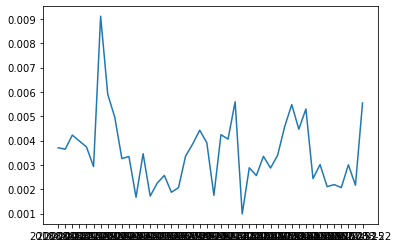

In [5]:
plt.plot(df.timeline, df.MAP)

In [3]:
#extract data between 2019-5-1 and 2019-6-1
mask = (transaction_raw.t_dat >= '2019-05-01') & (transaction_raw.t_dat <= '2019-06-01')
transaction_2019_May = transaction_raw.loc[mask].reset_index(drop=True)
transaction_2019_May

,t_dat,customer_id,article_id,price,sales_channel_id
0,2019-05-01,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,524061003,0.050831,2
1,2019-05-01,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,735404001,0.050831,2
2,2019-05-01,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,700370004,0.016932,2
3,2019-05-01,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,618800001,0.033881,2
4,2019-05-01,00019d6c20e0fbb551af18c57149af4707ec016bb0decd...,731407001,0.016932,2
...,...,...,...,...,...
1622933,2019-06-01,fffdaab7d9d79ceee4ffd2ab98bb68411438ea90e46a67...,738881002,0.016932,2
1622934,2019-06-01,fffdaab7d9d79ceee4ffd2ab98bb68411438ea90e46a67...,220094010,0.025407,2
1622935,2019-06-01,ffff4c4e8b57b633c1ddf8fbd53db16b962cf831baf9ed...,487800001,0.011847,2
1622936,2019-06-01,ffff4c4e8b57b633c1ddf8fbd53db16b962cf831baf9ed...,754013001,0.022017,2


In [8]:
len(MAP_results)

44

In [30]:
MAP12_cf = cf.MAP(recommend_items, X_test)
print("User-based collaborative filter MAP@12:", MAP12_cf)

100%|███████████████████████████████████████████████████████████████████████████| 24031/24031 [01:18<00:00, 307.11it/s]

Number of users: 4332
User-based collaborative filter MAP@12: 0.0037136724997412925


In [31]:
##Identify top 12 selling items for training data
top12items = list(X_train.head(100000).article_id.value_counts()[0:12].index)

#save top 12 selling items for users in a dict
top12_items = {}
for user in recommend_items:
    top12_items[user] = top12items

In [33]:
MAP12_top = cf.MAP(top12_items, X_test)
print("Top 12 selling products MAP@12:", MAP12_top)

100%|███████████████████████████████████████████████████████████████████████████| 24031/24031 [01:21<00:00, 295.16it/s]

Number of users: 4332
Top 12 selling products MAP@12: 0.0020729474647988057


In [38]:
# % increase in MAP@12
print("MAP@12 increases by", round(100*(MAP12_cf-MAP12_top)/MAP12_top), "%")

MAP@12 increases by 79 %
